<a href="https://colab.research.google.com/github/rezamohamadlo/Handwritten-Digits-Segmentation/blob/main/ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing the os module for interacting with the operating system
import os

# Importing the zipfile module to work with ZIP archives
import zipfile

# Importing necessary classes from the PIL (Pillow) library for image processing
import PIL.Image  # For opening and manipulating images
import PIL.ImageFont  # For working with fonts in images
import PIL.ImageDraw  # For drawing shapes and text on images

# Importing NumPy for numerical operations and array manipulations
import numpy as np

# Importing pyplot from matplotlib for data visualization
from matplotlib import pyplot as plt

# Importing TensorFlow, a popular library for machine learning and deep learning
import tensorflow as tf

# Importing TensorFlow Datasets (tfds) for accessing standard datasets easily
import tensorflow_datasets as tfds

# Importing train_test_split from scikit-learn to split datasets into training and testing sets
from sklearn.model_selection import train_test_split

In [3]:
# Use wget to download a ZIP file from a specified URL without checking the SSL certificate
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip \
    -O /tmp/m2nist.zip  # Save the downloaded file as m2nist.zip in the /tmp directory

# Define the path to the downloaded ZIP file
local_zip = '/tmp/m2nist.zip'

# Create a ZipFile object to read the downloaded ZIP file
zip_ref = zipfile.ZipFile(local_zip, 'r')

# Extract all contents of the ZIP file to the specified directory
zip_ref.extractall('/tmp/training')  # Extract files to /tmp/training directory

# Close the ZipFile object to free up system resources
zip_ref.close()

--2024-10-29 07:43:06--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  97.0MB/s    in 0.2s    

2024-10-29 07:43:07 (97.0 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



In [4]:
# Define the batch size for training
BATCH_SIZE = 32

def read_image_and_annotation(image, annotation):
    """
    Preprocesses the image and annotation by casting types,
    reshaping the image, normalizing pixel values, and returning them.

    Args:
        image: The input image tensor.
        annotation: The corresponding annotation tensor.

    Returns:
        A tuple containing the processed image and annotation.
    """
    # Cast the image to float32 type for processing
    image = tf.cast(image, dtype=tf.float32)

    # Reshape the image to add a channel dimension (for grayscale images)
    image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))

    # Cast the annotation to int32 type
    annotation = tf.cast(annotation, dtype=tf.int32)

    # Normalize pixel values to be between -1 and 1
    image = image / 127.5  # Scale from [0, 255] to [0, 2]
    image -= 1  # Shift to [-1, 1]

    return image, annotation


def get_training_dataset(images, annos):
    """
    Creates a training dataset from images and annotations,
    applying shuffling, batching, and prefetching for performance.

    Args:
        images: Array of training images.
        annos: Array of corresponding annotations.

    Returns:
        A TensorFlow Dataset object for training.
    """
    # Create a dataset from the images and annotations
    training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))

    # Apply the preprocessing function to each element in the dataset
    training_dataset = training_dataset.map(read_image_and_annotation)

    # Shuffle the dataset with a buffer size of 512
    training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)

    # Batch the dataset into groups of BATCH_SIZE
    training_dataset = training_dataset.batch(BATCH_SIZE)

    # Repeat the dataset indefinitely for continuous training
    training_dataset = training_dataset.repeat()

    # Prefetch batches for better performance during training
    training_dataset = training_dataset.prefetch(-1)

    return training_dataset


def get_validation_dataset(images, annos):
    """
    Creates a validation dataset from images and annotations,
    applying batching and repeating for evaluation purposes.

    Args:
        images: Array of validation images.
        annos: Array of corresponding annotations.

    Returns:
        A TensorFlow Dataset object for validation.
    """
    # Create a dataset from the images and annotations
    validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))

    # Apply the preprocessing function to each element in the dataset
    validation_dataset = validation_dataset.map(read_image_and_annotation)

    # Batch the dataset into groups of BATCH_SIZE
    validation_dataset = validation_dataset.batch(BATCH_SIZE)

    # Repeat the dataset indefinitely for evaluation
    validation_dataset = validation_dataset.repeat()

    return validation_dataset


def get_test_dataset(images, annos):
    """
    Creates a test dataset from images and annotations,
    applying batching without repeating.

    Args:
        images: Array of test images.
        annos: Array of corresponding annotations.

    Returns:
        A TensorFlow Dataset object for testing.
    """
    # Create a dataset from the images and annotations
    test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))

    # Apply the preprocessing function to each element in the dataset
    test_dataset = test_dataset.map(read_image_and_annotation)

    # Batch the dataset into groups of BATCH_SIZE, dropping any remainder
    test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

    return test_dataset


def load_images_and_segments():
   """
   Loads images and segmentation masks from .npy files,
   splits them into training, validation, and test sets.

   Returns:
       Tuple containing training, validation, and test datasets with annotations.
   """
   # Load images and segmentation masks from .npy files
   images = np.load('/tmp/training/combined.npy')
   segments = np.load('/tmp/training/segmented.npy')

   # Split data into training (80%) and validation (20%)
   train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)

   # Further split validation data into validation (80%) and test (20%)
   val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)

   return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)

In [5]:
# Load images and segmentation masks, splitting them into training, validation, and test sets
train_slices, val_slices, test_slices = load_images_and_segments()

# Create a training dataset using the training images and annotations
# train_slices[0] contains the training images
# train_slices[1] contains the corresponding training annotations
training_dataset = get_training_dataset(train_slices[0], train_slices[1])

# Create a validation dataset using the validation images and annotations
# val_slices[0] contains the validation images
# val_slices[1] contains the corresponding validation annotations
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])

# Create a test dataset using the test images and annotations
# test_slices[0] contains the test images
# test_slices[1] contains the corresponding test annotations
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

In [6]:
# Define the number of classes for segmentation
n_classes = 11

# Generate a list of random colors for each class, normalized to [0, 1]
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

def fuse_with_pil(images):
    """
    Combines multiple images into a single image using PIL.

    Args:
        images: List of images to be combined.

    Returns:
        A single PIL Image object containing all input images side by side.
    """
    # Calculate total width and maximum height for the new image
    widths = (image.shape[1] for image in images)
    heights = (image.shape[0] for image in images)
    total_width = sum(widths)
    max_height = max(heights)

    # Create a new blank image with the calculated dimensions
    new_im = PIL.Image.new('RGB', (total_width, max_height))

    # Paste each image into the new image
    x_offset = 0
    for im in images:
        pil_image = PIL.Image.fromarray(np.uint8(im))  # Convert NumPy array to PIL Image
        new_im.paste(pil_image, (x_offset, 0))  # Paste at the current x offset
        x_offset += im.shape[1]  # Update x offset for the next image

    return new_im


def give_color_to_annotation(annotation):
    """
    Converts a segmentation annotation to a color image.

    Args:
        annotation: A 2D array of class indices.

    Returns:
        A 3D array representing the colored segmentation image.
    """
    # Initialize an empty color image
    seg_img = np.zeros((annotation.shape[0], annotation.shape[1], 3)).astype('float')

    # Assign colors to each class in the annotation
    for c in range(n_classes):
        segc = (annotation == c)  # Create a binary mask for class c
        seg_img[:,:,0] += segc * (colors[c][0] * 255.0)  # Red channel
        seg_img[:,:,1] += segc * (colors[c][1] * 255.0)  # Green channel
        seg_img[:,:,2] += segc * (colors[c][2] * 255.0)  # Blue channel

    return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
    """
    Displays the original image, predicted segmentation, and true segmentation side by side.

    Args:
        image: The original input image.
        annotation: The ground truth segmentation annotation.
        prediction: The predicted segmentation from the model.
        iou_list: List of Intersection over Union scores for each class.
        dice_score_list: List of Dice scores for each class.

    Returns:
        None; displays images using matplotlib.
    """
    new_ann = np.argmax(annotation, axis=2)  # Convert one-hot encoded annotation to class indices
    true_img = give_color_to_annotation(new_ann)  # Colorize the true annotation
    pred_img = give_color_to_annotation(prediction)  # Colorize the predicted segmentation

    # Normalize and prepare the original image for display
    image = image + 1
    image = image * 127.5
    image = np.reshape(image, (image.shape[0], image.shape[1],))
    image = np.uint8(image)

    # Prepare images for display
    images = [image, np.uint8(pred_img), np.uint8(true_img)]

    # Collect metrics and sort by IOU score
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # Sort by IOU score

    # Create display strings for metrics
    display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n".join(display_string_list)

    plt.figure(figsize=(15, 4))

    # Display each of the images with appropriate titles and labels
    for idx, im in enumerate(images):
        plt.subplot(1, 3, idx + 1)
        if idx == 1:
            plt.xlabel(display_string)  # Show metrics under the prediction image
        plt.xticks([])
        plt.yticks([])
        plt.imshow(im)


def show_annotation_and_image(image, annotation):
    """
    Displays the original image alongside its segmentation annotation.

    Args:
        image: The original input image.
        annotation: The ground truth segmentation annotation.

    Returns:
        None; displays images using matplotlib.
    """
    new_ann = np.argmax(annotation, axis=2)  # Convert one-hot encoded annotation to class indices
    seg_img = give_color_to_annotation(new_ann)  # Colorize the true annotation

    # Normalize and prepare the original image for display
    image = image + 1
    image = image * 127.5
    image = np.reshape(image, (image.shape[0], image.shape[1],))

    image = np.uint8(image)

    # Prepare images for display
    images = [image, seg_img]

    # Fuse original and segmented images into one displayable format
    fused_img = fuse_with_pil(images)

    plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
   """
   Displays a grid of images along with their annotations from a dataset.

   Args:
       dataset: A TensorFlow Dataset object containing images and annotations.
       num_images: The number of images to display.

   Returns:
       None; displays images using matplotlib.
   """
   ds = dataset.unbatch()  # Unbatch the dataset to iterate over individual samples

   plt.figure(figsize=(20, 15))
   plt.title("Images And Annotations")
   plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

   # Iterate through the dataset and display specified number of images with annotations
   for idx, (image, annotation) in enumerate(ds.take(num_images)):
       plt.subplot(5, 5, idx + 1)
       plt.yticks([])
       plt.xticks([])
       show_annotation_and_image(image.numpy(), annotation.numpy())  # Convert tensors to numpy arrays for display

<ipython-input-6-fce1b11d62fb>:155: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


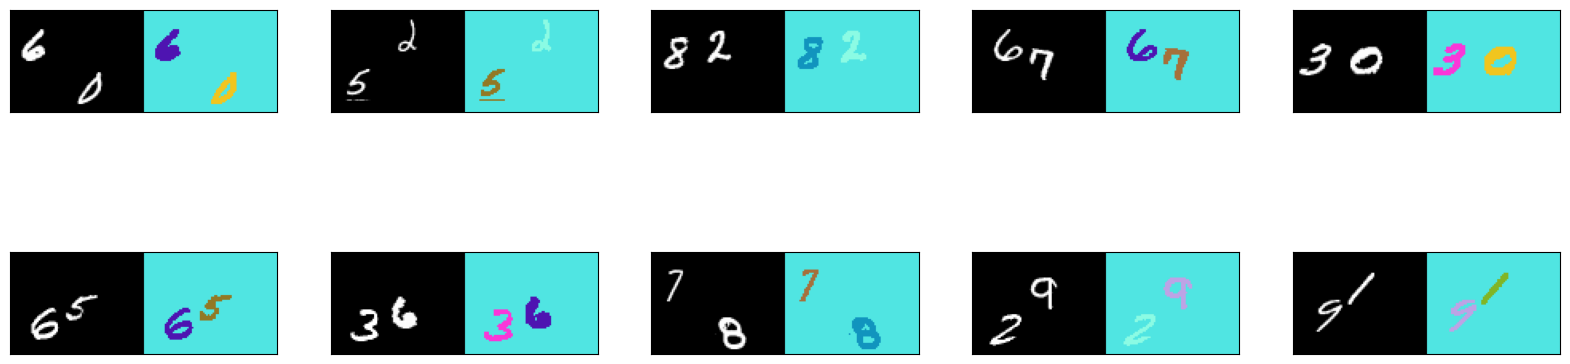

In [7]:
# Display a grid of 10 images along with their corresponding annotations from the training dataset
list_show_annotation(training_dataset, 10)

<ipython-input-6-fce1b11d62fb>:155: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


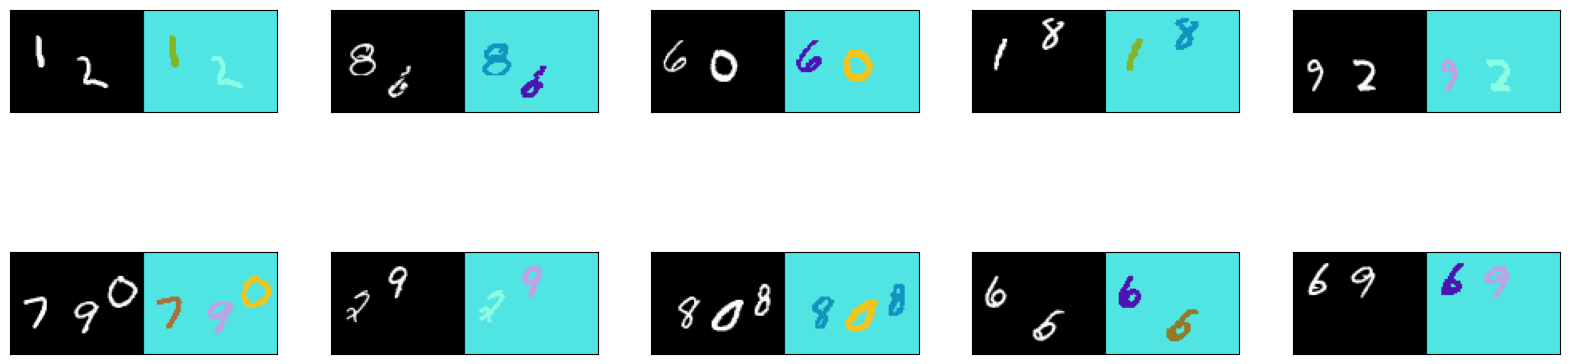

In [8]:
# Display a grid of 10 images along with their corresponding annotations from the validation dataset
list_show_annotation(validation_dataset, 10)

In [9]:
# Define the image ordering format; 'channels_last' means the shape is (batch_size, height, width, channels)
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides):
    """
    Creates a convolutional block consisting of two convolutional layers,
    followed by a max pooling layer and batch normalization.

    Args:
        input: Input tensor to the convolutional block.
        filters: Number of filters for the convolutional layers.
        kernel_size: Size of the convolutional kernel.
        pooling_size: Size of the pooling window.
        pool_strides: Strides for the pooling operation.

    Returns:
        A tensor that represents the output of the convolutional block.
    """
    # First convolutional layer with Leaky ReLU activation
    x = tf.keras.layers.Conv2D(filters,
                               kernel_size,
                               padding='same',  # Maintain input shape
                               data_format=IMAGE_ORDERING)(input)
    x = tf.keras.layers.LeakyReLU()(x)  # Apply Leaky ReLU activation

    # Second convolutional layer with Leaky ReLU activation
    x = tf.keras.layers.Conv2D(filters,
                               kernel_size,
                               padding='same',  # Maintain input shape
                               data_format=IMAGE_ORDERING)(x)
    x = tf.keras.layers.LeakyReLU()(x)  # Apply Leaky ReLU activation

    # Max pooling layer to downsample the feature maps
    x = tf.keras.layers.MaxPool2D(pooling_size,
                                  pool_strides,
                                  data_format=IMAGE_ORDERING)(x)

    # Batch normalization to stabilize and speed up training
    x = tf.keras.layers.BatchNormalization()(x)

    return x  # Return the output tensor of the convolutional block

In [10]:
# Create an input layer for the model with the specified shape
# The shape is (64, 84, 1), where 64 is the height, 84 is the width, and 1 is the number of channels (grayscale image)
test_input = tf.keras.layers.Input(shape=(64, 84, 1))

# Pass the input through the convolutional block defined earlier
# This will apply two convolutional layers, followed by max pooling and batch normalization
test_output = conv_block(test_input, 32, 3, 2, 2)

# Create a Keras model using the defined input and output
test_model = tf.keras.Model(inputs=test_input, outputs=test_output)

# Print a summary of the model architecture, including layer types and output shapes
print(test_model.summary())

# Clean up by deleting the variables to free up memory
del test_input, test_output, test_model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 84, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 84, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 84, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 42, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,696 (37.88 KB)

 Trainable params: 9,632 (37.62 KB)

 Non-trainable params: 64 (256.00 B)

None


In [11]:
def FCN8(input_height=64, input_width=84):
    """
    Constructs the FCN-8 architecture for image segmentation.

    Args:
        input_height: Height of the input images.
        input_width: Width of the input images.

    Returns:
        A tuple containing feature maps from specific layers and the input tensor.
    """

    # Create an input layer for the model with the specified shape
    img_input = tf.keras.layers.Input(shape=(input_height, input_width, 1))

    # Apply zero padding to adjust the width of the input to 96 pixels
    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96 - input_width)))(img_input)

    # Pass the padded input through several convolutional blocks
    x = conv_block(x, filters=32, kernel_size=3, pooling_size=2, pool_strides=2)  # First conv block
    x = conv_block(x, filters=64, kernel_size=3, pooling_size=2, pool_strides=2)  # Second conv block

    x = conv_block(x, filters=128, kernel_size=3, pooling_size=2, pool_strides=2)  # Third conv block
    f3 = x  # Save feature map from this layer for later use

    x = conv_block(x, filters=256, kernel_size=3, pooling_size=2, pool_strides=2)  # Fourth conv block
    f4 = x  # Save feature map from this layer for later use

    x = conv_block(x, filters=256, kernel_size=3, pooling_size=2, pool_strides=2)  # Fifth conv block
    f5 = x  # Save feature map from this layer for later use

    # Return the saved feature maps and the original input tensor
    return (f3, f4, f5), img_input

In [12]:
# Create the feature maps and input tensor by calling the FCN8 function
test_convs, test_img_input = FCN8()

# Create a Keras model using the defined input and output feature maps
# The model outputs a list containing the feature maps from the convolutional blocks and the original input
test_model = tf.keras.Model(inputs=test_img_input, outputs=[test_convs, test_img_input])

# Print a summary of the model architecture, including layer types and output shapes
print(test_model.summary())

# Clean up by deleting the variables to free up memory
del test_convs, test_img_input, test_model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 84, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 64, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 12, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 12, 128)          │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,354,784 (8.98 MB)

 Trainable params: 2,353,312 (8.98 MB)

 Non-trainable params: 1,472 (5.75 KB)

None


In [13]:
def fcn8_decoder(convs, n_classes):
    """
    Constructs the decoder part of the FCN-8 model, which upsamples the feature maps
    to produce a segmentation map.

    Args:
        convs: A tuple containing feature maps from the encoder part of the model.
        n_classes: The number of output classes for segmentation.

    Returns:
        A tensor representing the output segmentation map.
    """
    # Unpack feature maps from the encoder
    f3, f4, f5 = convs

    # Number of filters for the convolutional layers in the decoder
    n = 512

    # First convolutional layer in the decoder
    o = tf.keras.layers.Conv2D(n,
                               kernel_size=(7, 7),
                               activation='relu',
                               padding='same',
                               name="conv6",
                               data_format=IMAGE_ORDERING)(f5)
    o = tf.keras.layers.Dropout(0.5)(o)  # Apply dropout for regularization

    # Second convolutional layer in the decoder
    o = tf.keras.layers.Conv2D(n,
                               kernel_size=(1, 1),
                               activation='relu',
                               padding='same',
                               name="conv7",
                               data_format=IMAGE_ORDERING)(o)
    o = tf.keras.layers.Dropout(0.5)(o)  # Apply dropout for regularization

    # Final convolutional layer to produce class scores
    o = tf.keras.layers.Conv2D(n_classes,
                               kernel_size=(1, 1),
                               activation='relu',
                               padding='same',
                               data_format=IMAGE_ORDERING)(o)

    # Transpose convolution to upsample the feature map
    o = tf.keras.layers.Conv2DTranspose(n_classes,
                                        kernel_size=(4, 4),
                                        strides=(2, 2),
                                        use_bias=False,
                                        data_format=IMAGE_ORDERING)(o)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)  # Crop to match dimensions

    # Process feature map from f4 (skip connection)
    o2 = f4
    o2 = tf.keras.layers.Conv2D(n_classes,
                                kernel_size=(1, 1),
                                activation='relu',
                                padding='same',
                                data_format=IMAGE_ORDERING)(o2)

    # Add the two feature maps together
    o = tf.keras.layers.Add()([o, o2])

    # Another transpose convolution to further upsample
    o = tf.keras.layers.Conv2DTranspose(n_classes,
                                        kernel_size=(4, 4),
                                        strides=(2, 2),
                                        use_bias=False,
                                        data_format=IMAGE_ORDERING)(o)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)  # Crop to match dimensions

    # Process feature map from f3 (another skip connection)
    o2 = f3
    o2 = tf.keras.layers.Conv2D(n_classes,
                                kernel_size=(1, 1),
                                activation='relu',
                                padding='same',
                                data_format=IMAGE_ORDERING)(o2)

    # Add the two feature maps together again
    o = tf.keras.layers.Add()([o, o2])

    # Final transpose convolution to upsample to the original image size
    o = tf.keras.layers.Conv2DTranspose(n_classes,
                                        kernel_size=(8, 8),
                                        strides=(8, 8),
                                        use_bias=False,
                                        data_format=IMAGE_ORDERING)(o)

    # Crop to match the final output dimensions
    o = tf.keras.layers.Cropping2D(cropping=((0, 0), (0, 96 - 84)))(o)

    # Apply a sigmoid activation function to produce output probabilities
    o = (tf.keras.layers.Activation('sigmoid'))(o)

    return o  # Return the final output tensor representing the segmentation map

In [14]:
# Create the feature maps and input tensor by calling the FCN8 function
test_convs, test_img_input = FCN8()

# Pass the feature maps through the decoder to get the segmentation output
# Here, we assume there are 11 classes for segmentation
test_fcn8_decoder = fcn8_decoder(test_convs, 11)

# Print the shape of the output from the decoder
print(test_fcn8_decoder.shape)

# Clean up by deleting the variables to free up memory
del test_convs, test_img_input, test_fcn8_decoder

(None, 64, 84, 11)


In [15]:
# Create the feature maps and input tensor by calling the FCN8 function
convs, img_input = FCN8()

# Pass the feature maps through the decoder to get the segmentation output
# n_classes is assumed to be defined elsewhere in your code
dec_op = fcn8_decoder(convs, n_classes)

# Create a Keras model using the defined input and output
model = tf.keras.Model(inputs=img_input, outputs=dec_op)

In [16]:
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 64, 84, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 64, 96, 1)      │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 64, 96, 32)     │            320 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_22            │ (None, 64, 96, 32)     │              0 │ conv2d_25[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 64, 96, 32)     │          9,248 │ leaky_re_lu_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_23            │ (None, 64, 96, 32)     │              0 │ conv2d_26[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 32, 48, 32)     │              0 │ leaky_re_lu_23[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32, 48, 32)     │            128 │ max_pooling2d_11[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 32, 48, 64)     │         18,496 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_24            │ (None, 32, 48, 64)     │              0 │ conv2d_27[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 32, 48, 64)     │         36,928 │ leaky_re_lu_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_25            │ (None, 32, 48, 64)     │              0 │ conv2d_28[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 16, 24, 64)     │              0 │ leaky_re_lu_25[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 16, 24, 64)     │            256 │ max_pooling2d_12[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)   

 Total params: 9,061,985 (34.57 MB)

 Trainable params: 9,060,513 (34.56 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [17]:
# Compile the model with specified loss function, optimizer, and evaluation metrics
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,
                                                momentum=0.9,
                                                nesterov=True),
              metrics=['accuracy'])

In [18]:
# Define the number of epochs for training
EPOCHS = 170

# Calculate the number of steps per epoch based on the training dataset size and batch size
steps_per_epoch = 4000 // BATCH_SIZE  # Assuming 4000 training samples

# Calculate the number of validation steps based on the validation dataset size and batch size
validation_steps = 800 // BATCH_SIZE  # Assuming 800 validation samples

# Calculate the number of test steps based on the test dataset size and batch size
test_steps = 200 // BATCH_SIZE  # Assuming 200 test samples

# Train the model using the fit method
history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs=EPOCHS)

Epoch 1/170
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.4475 - loss: 1.7439 - val_accuracy: 0.9433 - val_loss: 0.4550
Epoch 2/170
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9428 - loss: 0.2333 - val_accuracy: 0.9433 - val_loss: 0.3560
Epoch 3/170
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9426 - loss: 0.2264 - val_accuracy: 0.9433 - val_loss: 0.2844
Epoch 4/170
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9427 - loss: 0.2207 - val_accuracy: 0.9433 - val_loss: 0.2293
Epoch 5/170
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9429 - loss: 0.2153 - val_accuracy: 0.9433 - val_loss: 0.2135
Epoch 6/170
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9427 - loss: 0.2114 - val_accuracy: 0.9433 - val_loss: 0.2074
Epoch 7/170
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9429 - loss: 0.2068 - val_accuracy: 0.9433 - val_loss: 0.2034
Epoch 8/170
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9426 - loss: 0.2041 -

In [19]:
# Use the model to make predictions on the test dataset
results = model.predict(test_dataset, steps=test_steps)

# Print the shape of the prediction results
print(results.shape)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
(192, 64, 84, 11)


In [20]:
# Use the model to make predictions on the test dataset
results = model.predict(test_dataset, steps=test_steps)

# Print the shape of the prediction results
print(results.shape)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(192, 64, 84, 11)


In [21]:
# Convert the predicted probabilities to class labels by taking the argmax along the channel axis
results = np.argmax(results, axis=3)

# Print the shape of the class label results
print(results.shape)

(192, 64, 84)


In [22]:
def class_wise_metrics(y_true, y_pred):
    """
    Calculates class-wise Intersection over Union (IoU) and Dice Score for segmentation results.

    Args:
        y_true: Ground truth segmentation labels (true classes).
        y_pred: Predicted segmentation labels (predicted classes).

    Returns:
        A tuple containing:
            - class_wise_iou: List of IoU scores for each class.
            - class_wise_dice_score: List of Dice scores for each class.
    """

    # Initialize lists to store IoU and Dice scores for each class
    class_wise_iou = []
    class_wise_dice_score = []

    # Small constant to avoid division by zero
    smoothing_factor = 0.00001

    # Loop over each class to calculate metrics
    for i in range(n_classes):
        # Calculate the intersection between true and predicted classes
        intersection = np.sum((y_pred == i) * (y_true == i))

        # Calculate the area of true positives and predicted positives
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))

        # Calculate the combined area (union)
        combined_area = y_true_area + y_pred_area

        # Calculate IoU using the formula: IoU = intersection / (union)
        iou = (intersection) / (combined_area - intersection + smoothing_factor)
        class_wise_iou.append(iou)

        # Calculate Dice Score using the formula: Dice = 2 * (intersection) / (true area + predicted area)
        dice_score = 2 * ((intersection) / (combined_area + smoothing_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

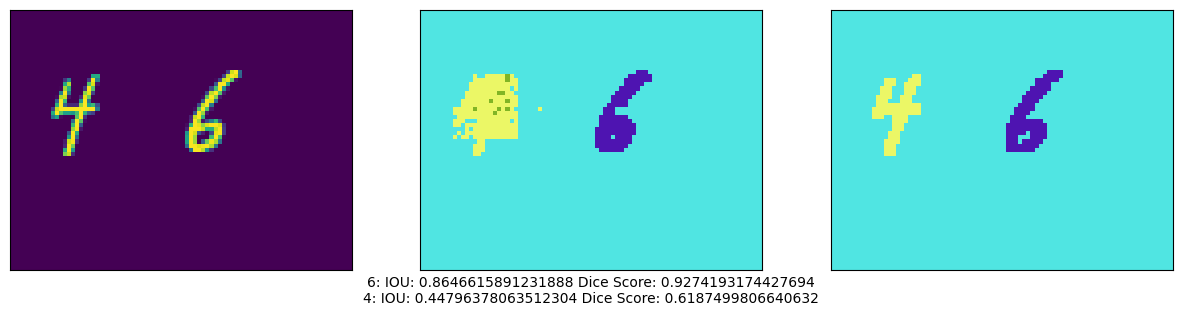

In [23]:
# Set an integer slider to select a specific sample from the dataset
integer_slider = 77

# Unbatch the test dataset to access individual samples
ds = test_dataset.unbatch()

# Batch the dataset into groups of 200 samples
ds = ds.batch(200)

# Initialize lists to hold images and true segmentations
images = []
y_true_segments = []

# Iterate over the dataset to retrieve images and annotations
for image, annotation in ds.take(2):
    y_true_segments = annotation  # Get the true segmentation annotations
    images = image  # Get the corresponding images

# Calculate Intersection over Union (IoU) and Dice Score for the selected sample
iou, dice_score = class_wise_metrics(
    np.argmax(y_true_segments[integer_slider], axis=2),  # Convert one-hot encoded annotations to class indices
    results[integer_slider]  # Use the predicted segmentation results
)

# Visualize the original image, true annotation, and predicted segmentation with metrics
show_annotation_and_prediction(
    images[integer_slider],  # Original input image
    y_true_segments[integer_slider],  # True segmentation annotation
    results[integer_slider],  # Predicted segmentation result
    iou,  # IoU scores for each class
    dice_score  # Dice scores for each class
)

In [25]:
# Calculate class-wise Intersection over Union (IoU) and Dice Score for all classes
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

# Initialize variable to calculate average IoU
average_iou = 0.0

# Iterate through each class's IoU and Dice Score (excluding the last class if it's a background)
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
    # Print the IoU and Dice Score for each class
    print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score))
    average_iou += iou  # Accumulate IoU for average calculation

# Calculate the average IoU
average_iou /= (n_classes - 1)  # Exclude the last class if it's a background

# Calculate the grade based on average IoU
grade = average_iou * 10

# Print the calculated grade
print("\nGrade is " + str(grade))



Digit 0: IOU: 0.7651245541128873 Dice Score: 0.8669354831987163
Digit 1: IOU: 0.7345607067477029 Dice Score: 0.8469703065336958
Digit 2: IOU: 0.7425423263335901 Dice Score: 0.8522516958264561
Digit 3: IOU: 0.4909655243421289 Dice Score: 0.6585873601051395
Digit 4: IOU: 0.47065448570810353 Dice Score: 0.6400612656228206
Digit 5: IOU: 0.6663261824238722 Dice Score: 0.7997548012534023
Digit 6: IOU: 0.6720130478836305 Dice Score: 0.8038370857622656
Digit 7: IOU: 0.7915046784859544 Dice Score: 0.8836199960748915
Digit 8: IOU: 0.5668824157854558 Dice Score: 0.7235800339252462
Digit 9: IOU: 0.41360894034852247 Dice Score: 0.5851815569963048

Grade is 6.314182862171847
